In [98]:
# import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from sklearn.model_selection import train_test_split


import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col


In [8]:
def get_ratings_data():
    '''
    Returns:
        ratings_contents (dataframe): has columns "user", "movie", "rating"
        ratings_as_mat (sparse matrix): rows correspond to users and columns correspond
        to movies. Each element is the user's rating for that movie.
    '''
    ratings_contents = pd.read_table("data/movies.dat",
                                     names=["user", "movie", "rating", 'timestamp'])
    ratings_as_mat = sparse.csr_matrix((ratings_contents.rating, 
        ((ratings_contents.user), (ratings_contents.movie))))
    return ratings_contents, ratings_as_mat

In [21]:
# ratings_contents, ratings_as_mat = get_ratings_data()

In [22]:
# schema = StructType([
#     StructField("user", IntegerType(), True),
#     StructField("movie", IntegerType(), True),
#     StructField("rating", IntegerType(), True),
#     StructField("timestamp", IntegerType(), True)])



# df_ratings = spark.read.csv('data/movies.dat',delimiter='::', header=False, schema=schema)

In [23]:
#df_ratings.show()

In [26]:
movies = pd.read_csv('data/movies.dat', sep='::', names=['movie', 'name', 'genre'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [27]:
movies.movies == 

,movie,name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [43]:
movies['genre'].unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

In [28]:
df = pd.read_csv('data/training.csv')

In [29]:
df.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [175]:
len(df['user'].unique())

5399

In [176]:
len(df['movie'].unique())

3662

In [30]:
df.describe()

,user,movie,rating,timestamp
count,800000.000000,800000.000000,800000.000000,8.000000e+05
mean,3403.097837,1849.257256,3.590479,9.683921e+08
std,1546.589028,1086.852485,1.120376,5.820931e+06
min,636.000000,1.000000,1.000000,9.567039e+08
25%,2035.000000,1028.000000,3.000000,9.641524e+08
50%,3507.000000,1788.000000,4.000000,9.675878e+08
75%,4695.000000,2750.000000,4.000000,9.746878e+08
max,6040.000000,3952.000000,5.000000,9.757673e+08


In [32]:
pivot_df = pd.pivot_table(df, values='rating', index='user', columns='movie' )

In [33]:
pivot_df

movie,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user,,,,,,,,,,,,,,,,,,,,,
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


In [37]:
users = pd.read_csv('data/users.dat', sep='::', names=['user', 'gender', 'age', 'occupation', 'zipcode'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [42]:
users

,user,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [44]:
from sklearn.preprocessing import MultiLabelBinarizer

In [45]:
keywords = pd.read_csv('data/keywords.csv')

In [54]:
keys = pd.read_json('data/keywords.csv')

ValueError: Expected object or value

In [49]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [53]:
movies[movies.movie == 862]

,movie,name,genre
851,862,Manny & Lo (1996),Drama


In [50]:
keywords.describe()

,id
count,46419.000000
mean,109769.951873
std,113045.780256
min,2.000000
25%,26810.500000
50%,61198.000000
75%,159908.500000
max,469172.000000


In [57]:
keywords['keywords'][0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [62]:
movies.head()

,movie,name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [70]:
import json
import ast 
from functools import reduce

In [ ]:
reduce()

In [75]:
def word(w):
    return w

In [76]:
x = reduce(word, map(lambda x: x.get('name'), ast.literal_eval(keywords['keywords'][0])))

TypeError: word() takes 1 positional argument but 2 were given

In [82]:
def plot_parser(row, key='name'):
    return list(map(lambda x: x.get(key), ast.literal_eval(row)))
    
    

In [88]:
movies.head(11)

,movie,name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [85]:
keywords = keywords.keywords.apply(plot_parser)

In [91]:
keys = pd.DataFrame(keywords)

In [93]:
keys.to_csv('data/keys.csv')

In [80]:
list(map(lambda x: x.get('name'), ast.literal_eval(keywords['keywords'][0])))

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [95]:
keys.head()

,keywords
0,"[jealousy, toy, boy, friendship, friends, riva..."
1,"[board game, disappearance, based on children'..."
2,"[fishing, best friend, duringcreditsstinger, o..."
3,"[based on novel, interracial relationship, sin..."
4,"[baby, midlife crisis, confidence, aging, daug..."


In [ ]:
keywords.keywords.

In [96]:
#pd.DataFrame(keywords.keywords.values)

# Similarity Based Recommendations

In [99]:
df.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [100]:
def hist_of_df(df, user_item):
    pivot = df.pivot_table(values='rating',index='user',columns='movie')
    ratings = (pivot > 0).sum(axis=user_item)
    ratings.hist(bins=100)
    print('Min number of ratings: {}'.format(ratings.min()))

In [101]:
train, test = train_test_split(df, random_state = 100)

Min number of ratings: 1


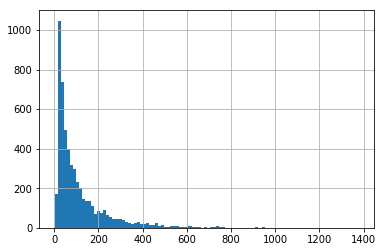

In [103]:
hist_of_df(train, 1)
#hist of users

Min number of ratings: 1


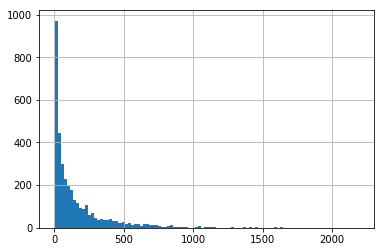

In [104]:
hist_of_df(train, 0)
#hist of items

In [105]:
# Number of users that are in train and not test
len( np.setdiff1d(test.user.unique(), train.user.unique()))

1

In [106]:
# Number of movies in train and not test
len( np.setdiff1d(test.movie.unique(), train.movie.unique()))

41

In [109]:
average_rating = df.groupby('movie').mean()['rating']
average_rating.head(10)


movie
1     4.145226
2     3.197880
3     3.023560
4     2.701493
5     2.995781
6     3.871665
7     3.430986
8     2.961538
9     2.675000
10    3.520833
Name: rating, dtype: float64

In [110]:
movies.loc[average_rating.idxmax()]

movie                                                  797
name     Old Lady Who Walked in the Sea, The (Vieille q...
genre                                               Comedy
Name: 787, dtype: object

In [113]:
from src.ItemItemRecommender import ItemItemRecommender

(array([ 12.,   0.,  45.,   0.,   0., 109.,   0., 115.,   0.,  46.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

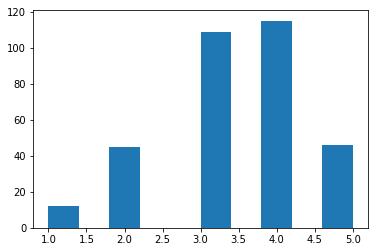

In [128]:
plt.hist(train.loc[train['movie'] == 163].rating)

In [111]:
ratings_as_mat = csr_matrix((train.rating, 
        ((train.user), (train.movie))))

In [114]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [115]:
rec.pred_one_user(user_id=1)

/Users/emilykarboski/gal/assignments/dsi-movie-recommender/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


array([0., 0., 0., ..., 0., 0., 0.])

In [116]:
movies.loc[rec.top_n_recs(user_id=1, n=10)]

/Users/emilykarboski/gal/assignments/dsi-movie-recommender/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,movie,name,genre
1317,1337.0,"Body Snatcher, The (1945)",Horror
1318,1339.0,Bram Stoker's Dracula (1992),Horror|Romance
1319,1340.0,Bride of Frankenstein (1935),Horror
1320,1341.0,Burnt Offerings (1976),Horror
1321,1342.0,Candyman (1992),Horror
1322,1343.0,Cape Fear (1991),Thriller
1323,1344.0,Cape Fear (1962),Film-Noir|Thriller
1324,1345.0,Carrie (1976),Horror
1326,1347.0,"Nightmare on Elm Street, A (1984)",Horror
3952,NaN,NaN,NaN


In [117]:
test.groupby('user').count().head(15)

,movie,rating,timestamp
user,,,
636,19,19,19
637,112,112,112
638,27,27,27
639,22,22,22
640,9,9,9
641,12,12,12
642,5,5,5
643,15,15,15
644,31,31,31


In [122]:
user_642 = test[test.user == 642]
user_650 = test[test.user == 650]

In [123]:
predictions642 = rec.pred_one_user(user_id=642)
predictions650 = rec.pred_one_user(user_id=650)

/Users/emilykarboski/gal/assignments/dsi-movie-recommender/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


In [121]:
user_642['prediction'] = predictions[test[test.user == 642].movie.values]
user_642

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user,movie,rating,timestamp,prediction
797484,642,2639,1,975720744,4.000000
797494,642,2762,5,975721471,4.234193
797486,642,1196,3,975720788,4.000000
797487,642,2406,5,975720788,4.000000
797504,642,3354,4,975721646,4.215685


In [124]:
user_650['prediction'] = predictions[test[test.user == 650].movie.values]
user_650

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user,movie,rating,timestamp,prediction
795908,650,163,5,975704447,0.0
795973,650,2804,5,975704799,4.0
795909,650,110,5,975704447,4.0
795916,650,1047,4,975704475,0.0
795872,650,2144,5,975704265,4.0
795978,650,1259,4,975704828,4.0
795927,650,2167,3,975704514,4.0


In [134]:
len(df['movie'].unique())

3662

In [133]:
len(movies['movie'].unique())

3883

In [146]:
#predictions_df = predictions.values.toPandas().fillna(train['rating'].mean())
#predictions['squared_error'] = (predictions['rating'] - predictions['prediction'])**2

In [144]:
len(predictions)

3953

In [145]:
len(test)

200000

In [149]:
unique_users = test['user'].unique()

In [154]:
master_df = pd.DataFrame(columns=['user', 'movie', 'rating', 'timestamp', 'prediction'] )
master_df.head()

,user,movie,rating,timestamp,prediction


In [157]:
user_pred = []
for user in unique_users:
    pred_arr = rec.pred_one_user(user_id=user)
    user_pred.append(pred_arr)
    
    
    

/Users/emilykarboski/gal/assignments/dsi-movie-recommender/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


KeyboardInterrupt: 

In [161]:
len(user_pred)

1569

In [163]:
unique_users[:10]

array([3578, 2102, 2156, 5996, 3277, 5622, 5972, 2259, 2641, 5801])

In [170]:
user_3578 = test[test.user == 3578]
user_3578['prediction'] = predictions[test[test.user == 3578].movie.values]
user_3578['squared_error'] = (user_3578['rating'] - user_3578['prediction'])**2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [173]:
np.sqrt(user_3578['squared_error'].sum()/len(user_3578))

1.6577026497319065

In [172]:
user_3578

,user,movie,rating,timestamp,prediction,squared_error
365867,3578,1627,3,966711901,4.000000,1.000000e+00
365876,3578,2054,3,966711999,4.000000,1.000000e+00
365457,3578,1220,3,966709923,4.000000,1.000000e+00
365512,3578,2532,1,966710220,4.194690,1.020604e+01
365678,3578,1904,3,966710888,0.000000,9.000000e+00
365448,3578,1374,4,966709832,4.154104,2.374801e-02
365497,3578,1858,4,966710142,4.000000,0.000000e+00
365458,3578,3418,4,966709952,4.000000,0.000000e+00
365667,3578,2321,4,966710861,4.000000,0.000000e+00
365456,3578,2924,4,966709923,4.000000,0.000000e+00


In [135]:
from pyspark.ml.recommendation import ALS


def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    """
    grid search function to select the best model based on RMSE of
    validation data
    Parameters
    ----------
    train_data: spark DF with columns ['userId', 'movieId', 'rating']
    
    validation_data: spark DF with columns ['userId', 'movieId', 'rating']
    
    maxIter: int, max number of learning iterations
    
    regParams: list of float, one dimension of hyper-param tuning grid
    
    ranks: list of float, one dimension of hyper-param tuning grid
    
    Return
    ------
    The best fitted ALS model with lowest RMSE score on validation data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = ALS().setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [136]:
def make_recommendations(self, fav_movie, n_recommendations):
    """
    make top n movie recommendations
    Parameters
    ----------
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    """
    # get data
    movie_user_mat_sparse, hashmap = self._prep_data()
    # get recommendations
    raw_recommends = self._inference(
        self.model, movie_user_mat_sparse, hashmap,
        fav_movie, n_recommendations)
    # print results
    reverse_hashmap = {v: k for k, v in hashmap.items()}
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance '
              'of {2}'.format(i+1, reverse_hashmap[idx], dist))